In [3]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt



s3= boto3.resource('s3')
bucket_name= 'morgangant-bata-445-bucket'
bucket= s3.Bucket(bucket_name)

file_key= 'weather.csv'

bucket_object= bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

#reading the datefile
weather = pd.read_csv(file_content_stream)
weather.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


In [4]:
#deleting rows after 2011-10-31
weather=weather.drop(weather.index[117793:])

In [43]:
len(weather)

117793

In [5]:
weather= weather.dropna()

In [45]:
len(weather)

117759

In [6]:
#Setting input variables
weather= weather.drop(columns= ['rowID', 'hpwren_timestamp', 'min_wind_direction', 'min_wind_speed', 'rain_accumulation', 'rain_duration'], axis= 1)

In [7]:
#standardizing data
scaler= MinMaxScaler().fit(weather)
x= scaler.transform(weather)
x

#defining the numbe rof clusters to be considered
krange= list(range(2,21))

#defining lists to store scores
Sill_scores= list()

for i in krange:

    #Define k-means model
    cluster_md= KMeans(n_clusters= i, n_init= 20).fit(x)
    cluster_assignments= cluster_md.labels_
   
    #extract CH, DB and sill scores
    Sill= silhouette_score(x, cluster_assignments)
    
    #storing scores
    Sill_scores.append(Sill)

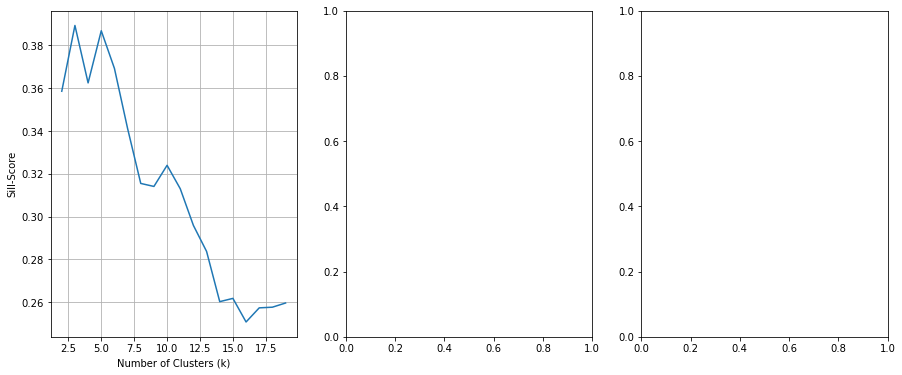

In [8]:
#visulizing the scores
fig, axs = plt.subplots(1, 3, figsize = (15, 6))
axs[0].plot(krange, Sill_scores)
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('Sill-Score')
axs[0].grid()

In [ ]:
#The number of clusters the Sill test recommends is about 3 clusters

In [9]:
#Clustering the data
three_clusters= KMeans(n_clusters= 3, n_init= 20).fit(x)

#Append cluster labels 
weather['cluster']= three_clusters.labels_
weather.head(10)

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,cluster
1,912.3,63.86,161.0,0.8,215.0,1.5,39.9,2
2,912.3,64.22,77.0,0.7,143.0,1.2,43.0,0
3,912.3,64.40,89.0,1.2,112.0,1.6,49.5,0
4,912.3,64.40,185.0,0.4,260.0,1.0,58.8,2
5,912.3,63.50,76.0,2.5,92.0,3.0,62.6,0
6,912.3,62.78,79.0,2.4,89.0,2.7,65.6,0
7,912.3,62.42,86.0,2.0,92.0,2.4,65.2,0
8,912.3,62.24,105.0,1.4,125.0,1.9,65.8,1
9,912.3,62.24,93.0,0.4,126.0,0.7,58.6,0
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5,2


In [ ]:
#Describing the clusters
#0: Lower average wind directions and lower max wind direction
#1: Middle average wind directions and middle max wind direction
#2: Highest average wind directions and highest max wind direction
#The biggest distinction I see between clusters is with max_wind_direction.
    #Higher number clusters have higher average wind direction before the 
    #the timestamp
#There is also a relationship between avg_wind_direction. The higher the cluster 
    #the higher the average wind direction. 
#These cluster relationships aren't very distict though, the values
    #have a close range. And for as many variables as we are using, I feel 
    #as though we should a better relationship between more variables
    #and the cluster. 
    #Note: This may be becasue we are only using 2 months of the collected
        #data and the weather might not vary too much during this time, depening
        #on many factors. If we open up our data to more of what was recorded,
        #we might be able to see more specific relationships. 
    